In [265]:
def max_carbon(stringlike, carbon):
    """ 
    params:
    =======
    stringlike: <str> like residue, like "20:3"
    carbon    : <int> The maximum number of carbon atoms allowed.
    
    returns:
    ========
    True if <stringlike> within <carbon> allowed number of residues, False otherwise
    """
    if not isinstance(carbon, (int, float)):
        raise TypeError(f"Max carbon atoms must be a number")
    
    try:
        backbone = int(stringlike[:stringlike.find(":")])
        
        if backbone <= carbon:
            return True
        else:
            return False
    except (TypeError, ValueError):
        raise TypeError(f"'{stringlike}' must be in the form (example): '20:3'")

In [266]:
def saturated(stringlike):
    """ Accepts strings in the form: 20:3
    Returns True if fatty residue is saturated, False otherwise.
    
    params:
    =======
    stringlike: <str> like residue, like "20:3"
    
    returns:
    ========
    True if the residue is saturated, False otherwise
    """
    try:
        sat = int(stringlike[stringlike.find(":")+1:])
        if sat > 0:
            return False
        else:
            return True
    except (TypeError, ValueError):
        raise TypeError(f"'{stringlike}' must be in the form (example): '20:3'")


In [479]:
# Author: stefano.manzini@gmail.com
# http://www.stemanz.altervista.org/
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from liputils import Lipid
import pandas as pd
import numpy as np
from collections import Counter

This is an exploratory analysis of publicly available data from:
https://www.metabolomicsworkbench.org/data/DRCCMetadata.php?Mode=Study&StudyID=ST000668&StudyType=MS&ResultType=1

This data is available at the NIH Common Fund's National Metabolomics Data Repository (NMDR) website, the Metabolomics Workbench, https://www.metabolomicsworkbench.org, where it has been assigned Project ID PR000471. The data can be accessed directly via it's Project DOI: 10.21228/M85P6M This work is supported by NIH grant, U2C- DK119886.

# Data preprocessing

In [54]:
# manual inspection of the downloaded files is required to know how many rows
# need to be skipped to yield a non-malformed table
df1 = pd.read_csv("ST000668_AN001022.csv", sep="\t", skiprows=109)
df2 = pd.read_csv("ST000668_AN001023.csv", sep="\t", skiprows=109)

In [55]:
# analytes contain information that prevent Metabolomics Workbench
# name translator from understanding who they are
# https://www.metabolomicsworkbench.org/databases/refmet/name_to_refmet.php
# example: CL 70:1; [M-2H](2-)@6.86
# it needs to be: CL 70:1

df1["Samples"] = df1["Samples"].apply(lambda x: x[:x.find(";")] if ";" in x else x)
df1["Samples"] = df1["Samples"].apply(lambda x: x[:x.find("[")] if "]" in x else x)
df2["Samples"] = df2["Samples"].apply(lambda x: x[:x.find(";")] if ";" in x else x)
df2["Samples"] = df2["Samples"].apply(lambda x: x[:x.find("[")] if "[" in x else x)

In [56]:
# the last two rows do not contain lipidomics data:
df1["Samples"][-3:]

248    plasmenyl-PE 42:5
249      METABOLITES_END
250                 #END
Name: Samples, dtype: object

In [57]:
df1 = df1.iloc[:-2,:]
df2 = df2.iloc[:-2,:]

In [58]:
#checking if columns are equal. If they are, we merge the two dataframes
for x,y in zip(df1.columns, df2.columns):
    assert x == y

In [59]:
df = pd.concat([df1, df2], axis=0)

In [60]:
# this study uses a notation that is not RefMet compliant. We need to get
# online and retrieve translated terms from
# https://www.metabolomicsworkbench.org/databases/refmet/name_to_refmet.php

In [61]:
df = df.set_index("Samples")

In [62]:
# making a textfile with all analytes
with open("analytes.txt", "w") as o:
    for analyte in df.index:
        o.write(analyte+"\n")

In [63]:
# after manually inputting the analyte list in Metabolomics Workbench, a
# txt table of translated inputs is dowloaded. We load this table:
translated = pd.read_csv("refmet_results.txt", sep="\t")
translated.head(10)

,Input name,RefMet name,Formula,Mass,REGNO
0,Factors,NaN,NaN,NaN,NaN
1,CL 70:1,CL(70:1),C79H152O17P2,1435.0505,NaN
2,CL 70:5,CL(70:5),C79H144O17P2,1426.9879,NaN
3,CL 74:1,CL(74:1),C83H160O17P2,1491.1131,NaN
4,CL 74:7,CL(74:7),C83H148O17P2,1479.0192,NaN
5,CL 82:13,NaN,NaN,NaN,NaN
6,FFA(20:0),Arachidic acid,C20H40O2,312.3028,41.0
7,FFA(20:1),Heneicosenoic acid,C21H40O2,324.3028,NaN
8,FFA(20:2),Eicosadienoic acid,C20H36O2,308.2715,NaN
9,FFA(22:0),Behenic acid,C22H44O2,340.3341,43.0


In [64]:
# not all inputs were translated (Factors, on row 0, is an artifact from the old index)
translated.iloc[0,1] = "Factors"

In [65]:
assert df.shape[0] == translated.shape[0]

In [66]:
# The tables have the same number of rows, so we can put the translated
# indices back into the former table, then drop all non translated
# compound (this is why we put back "Factors", as we still need to give labels
# to samples)

In [67]:
df["RefMet name"] = list(translated["RefMet name"])
df = df.dropna()
print(f"Total number of lipids: {df.shape[0]}")

Total number of lipids: 482


In [68]:
# it would be a good thing to rapidly identify each sample in terms of treatment,
# as well as stratify data. Let's get to know the different experimental conditions:
print(f"These are the possible experimental conditions:\n{'='*80}")
for c in set(df.loc["Factors",df.columns[:-1]]):
    print(c)

These are the possible experimental conditions:
Diet intervention:Baseline | Gender:female
Diet intervention:Overfeeding-2 weeks | Gender:female
Diet intervention:Overfeeding-2 weeks | Gender:male
Diet intervention:Saturated Fatty Acid | Gender:female
Diet intervention:Baseline | Gender:male
Diet intervention:Unsaturated Fatty Acid | Gender:female


In [69]:
# we are going to modify the table a bit, so we save some info about
# the samples for future reference
sample_book = {k:v for k,v in zip(df.columns[:-1], df.loc["Factors", df.columns[:-1]])}

In [70]:
# final preparation of the table for residue extraction. Setting the index with
# RefMet compliant lipid names
df = df.set_index("RefMet name")

In [71]:
df = df.drop(["Factors"])

In [82]:
# liputils drops any non-numerical column by default.
# pandas has not interpreted the numbers in the table as numbers,
# so before proceeding we tell it that the table actually contains numbers.
df = df.astype("float64")

# Extraction of lipid residues with liputils

In [93]:
res = make_residues_table(df)
res = res.sort_index()
res.head()

,S00019182,S00019183,S00019184,S00019185,S00019186,S00019187,S00019188,S00019189,S00019190,S00019191,...,S00019216,S00019217,S00019218,S00019219,S00019220,S00019221,S00019222,S00019223,S00019224,S00019225
14:0,3.474830e+04,4.356682e+04,2.608958e+04,3.404043e+04,2.561295e+04,2.388370e+04,2.784819e+04,5.753333e+04,4.727178e+04,8.105572e+04,...,2.863098e+04,2.468267e+04,4.875938e+04,4.959093e+04,1.870315e+04,5.526549e+04,2.354257e+04,5.574129e+04,3.363493e+04,4.496900e+04
15:0,2.600530e+04,2.938390e+04,4.065718e+04,4.502925e+04,2.922490e+04,2.326481e+04,2.239081e+04,5.210336e+04,4.248189e+04,1.085333e+05,...,2.843382e+04,2.659046e+04,4.369342e+04,5.634652e+04,3.608747e+04,4.379139e+04,2.900105e+04,4.852347e+04,4.088229e+04,3.831359e+04
16:0,7.674743e+06,5.166182e+06,9.504088e+06,7.029468e+06,5.438244e+06,3.908616e+06,4.446123e+06,4.709572e+06,8.092132e+06,1.333180e+07,...,7.089357e+06,4.895125e+06,1.046341e+07,1.001964e+07,1.001764e+07,1.265982e+07,7.317892e+06,1.235234e+07,9.119320e+06,9.112761e+06
16:1,7.453597e+04,9.748588e+04,1.343240e+05,1.057079e+05,1.047244e+05,7.011630e+04,8.646578e+04,8.659061e+04,1.802403e+05,1.894745e+05,...,9.840092e+04,8.723824e+04,1.415048e+05,2.003661e+05,9.639443e+04,1.790935e+05,8.576532e+04,2.776983e+05,1.018086e+05,1.466338e+05
17:0,5.063393e+04,4.928738e+04,4.719015e+04,4.265817e+04,4.911188e+04,3.892206e+04,3.906272e+04,3.765833e+04,3.992683e+04,5.643548e+04,...,4.534294e+04,3.645196e+04,5.426568e+04,4.462201e+04,4.555003e+04,5.619543e+04,5.006530e+04,3.354556e+04,6.105754e+04,4.255427e+04


In [95]:
print(f"A total of {len(res.index)} individual residues have been extracted.")

A total of 212 individual residues have been extracted.


In [128]:
# switching rows to columns for easier plotting
data = res.T

# giving some labels
def get_diet(stringlike):
    if "Overfeeding-2 weeks" in stringlike:
        return "Overfeeding"
    elif "Baseline" in stringlike:
        return "Baseline"
    elif "Unsaturated" in stringlike:
        return "Unsaturated fats"
    elif "Saturated" in stringlike:
        return"Saturated fats"
    else:
        return "unrecognized diet"


# adding some labels to data
data["sex"]  = ["female" if "female" in sample_book.get(x) else "male" for x in data.index]
data["diet"] = [get_diet(sample_book.get(x)) for x in data.index]

abuntand saturated residues


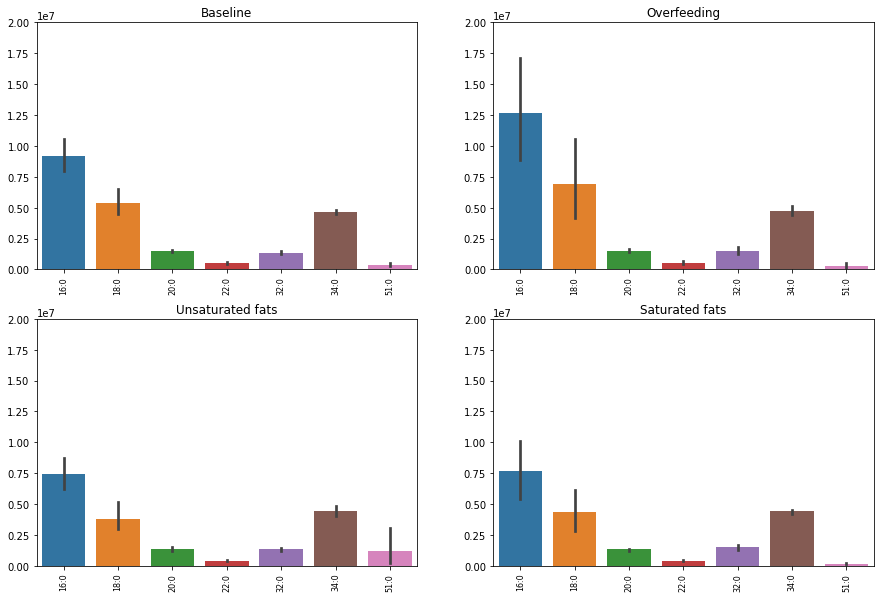

In [177]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))
label = "diet"
labelled_columns = 2

for coord in ((0,0,"Baseline"),(0,1,"Overfeeding"),(1,0,"Unsaturated fats"),(1,1,"Saturated fats")):
    i,j,group = coord
    
    axes[i,j].set_title(f"{group}")
    
    # applying a threshold. Give >= 0 to keep everything
    # ==================================================
    cols = data._get_numeric_data().mean() >= 400_000
    cols_to_keep = cols[cols].index
    table = data[cols_to_keep]
    
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[saturated(x) for x in table.columns]]
    
    # putting back sample labels
    table = pd.concat([table, data[data.columns[-labelled_columns:]]], axis=1)   
    
    table=table[table[label] == group]
    
    # we needed to put back the labels to drop non-group rows, now
    # we just need to plot the numbers
    table=table[table.columns[:-labelled_columns]] # only residue columns
    
    bar = sns.barplot(data=table, ax=axes[i, j])
    axes[i,j].tick_params(rotation=90, labelsize=8, axis="x")
    axes[i,j].tick_params(labelsize=10, axis="y")
    axes[i,j].set_ylim(0, 20_000_000)

print("abundant saturated residues")

not abundant saturated residues


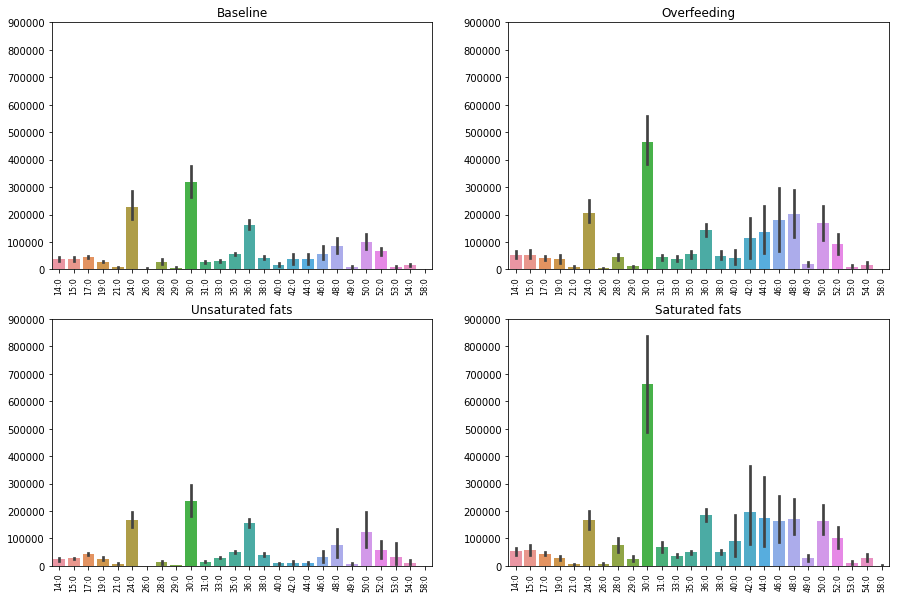

In [189]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))
label = "diet"
labelled_columns = 2

for coord in ((0,0,"Baseline"),(0,1,"Overfeeding"),(1,0,"Unsaturated fats"),(1,1,"Saturated fats")):
    i,j,group = coord
    
    axes[i,j].set_title(f"{group}")
    
    # applying a threshold. Give >= 0 to keep everything
    # ==================================================
    cols = data._get_numeric_data().mean() < 400_000
    cols_to_keep = cols[cols].index
    table = data[cols_to_keep]
    
    # saturated or insaturated?
    # =========================
    sub_cols = [saturated(x) for x in table.columns]
    table = table.loc[:,sub_cols]
    
    # putting back sample labels
    table = pd.concat([table, data[data.columns[-labelled_columns:]]], axis=1)   
    
    table=table[table[label] == group]
    
    # we needed to put back the labels to drop non-group rows, now
    # we just need to plot the numbers
    table=table[table.columns[:-labelled_columns]] # only residue columns
    
    bar = sns.barplot(data=table, ax=axes[i, j])
    axes[i,j].tick_params(rotation=90, labelsize=8, axis="x")
    axes[i,j].tick_params(labelsize=10, axis="y")
    axes[i,j].set_ylim(0, 900_000)

print("not abundant saturated residues")

abundant saturated residues


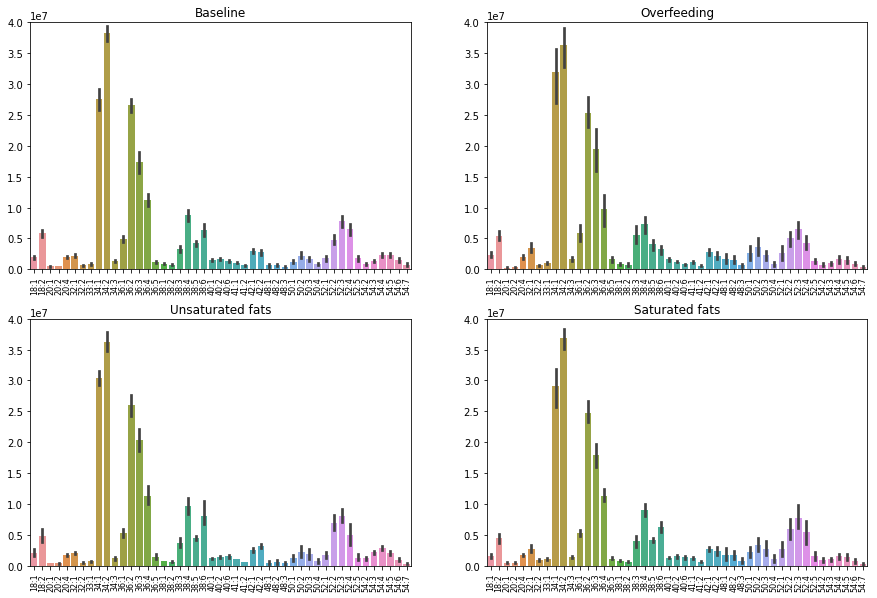

In [192]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))
label = "diet"
labelled_columns = 2

for coord in ((0,0,"Baseline"),(0,1,"Overfeeding"),(1,0,"Unsaturated fats"),(1,1,"Saturated fats")):
    i,j,group = coord
    
    axes[i,j].set_title(f"{group}")
    
    # applying a threshold. Give >= 0 to keep everything
    # ==================================================
    cols = data._get_numeric_data().mean() >= 400_000
    cols_to_keep = cols[cols].index
    table = data[cols_to_keep]
    
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[not saturated(x) for x in table.columns]]
    
    # putting back sample labels
    table = pd.concat([table, data[data.columns[-labelled_columns:]]], axis=1)   
    
    table=table[table[label] == group]
    
    # we needed to put back the labels to drop non-group rows, now
    # we just need to plot the numbers
    table=table[table.columns[:-labelled_columns]] # only residue columns
    
    bar = sns.barplot(data=table, ax=axes[i, j])
    axes[i,j].tick_params(rotation=90, labelsize=8, axis="x")
    axes[i,j].tick_params(labelsize=10, axis="y")
    axes[i,j].set_ylim(0, 40_000_000)

print("abundant unsaturated residues")

non abundant unsaturated residues


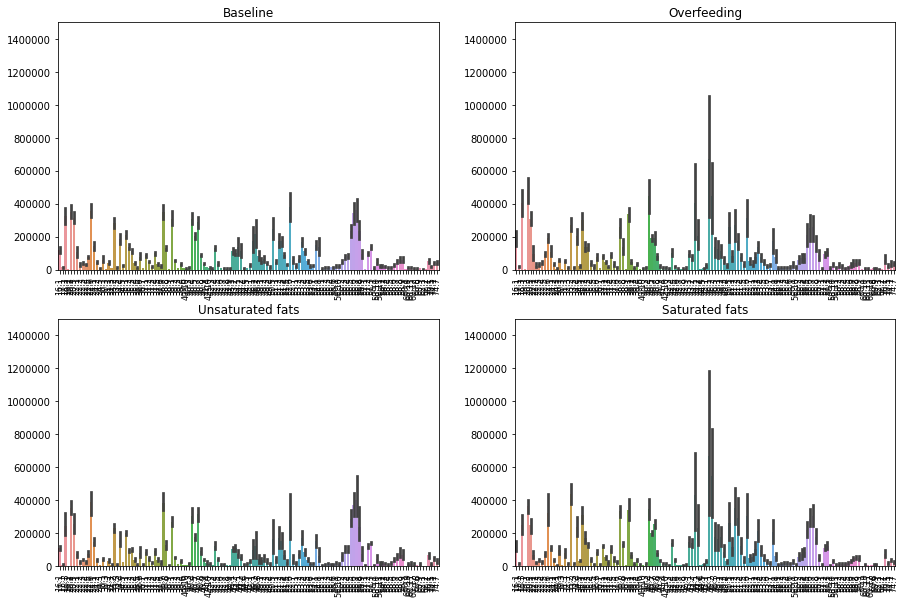

In [196]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))
label = "diet"
labelled_columns = 2

for coord in ((0,0,"Baseline"),(0,1,"Overfeeding"),(1,0,"Unsaturated fats"),(1,1,"Saturated fats")):
    i,j,group = coord
    
    axes[i,j].set_title(f"{group}")
    
    # applying a threshold. Give >= 0 to keep everything
    # ==================================================
    cols = data._get_numeric_data().mean() < 400_000
    cols_to_keep = cols[cols].index
    table = data[cols_to_keep]
    
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[not saturated(x) for x in table.columns]]
    
    # putting back sample labels
    table = pd.concat([table, data[data.columns[-labelled_columns:]]], axis=1)   
    
    table=table[table[label] == group]
    
    # we needed to put back the labels to drop non-group rows, now
    # we just need to plot the numbers
    table=table[table.columns[:-labelled_columns]] # only residue columns
    
    bar = sns.barplot(data=table, ax=axes[i, j])
    axes[i,j].tick_params(rotation=90, labelsize=8, axis="x")
    axes[i,j].tick_params(labelsize=10, axis="y")
    axes[i,j].set_ylim(0, 1_500_000)

print("non abundant unsaturated residues")

# keeping unambiguos residues

In [337]:
res = make_residues_table(df, drop_ambiguous=True)
res = res.sort_index()

abundant saturated residues


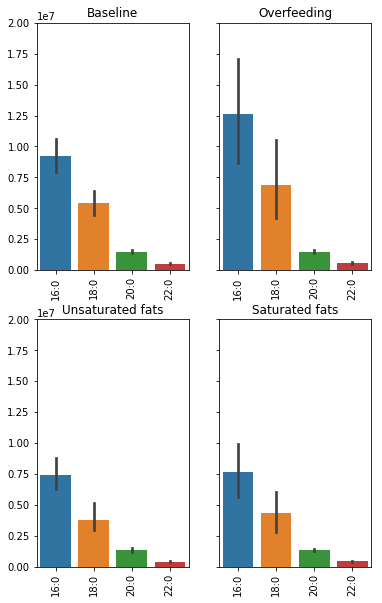

In [343]:
fig, axes = plt.subplots(2, 2, figsize=(6,10))
label = "diet"
labelled_columns = 2

for coord in ((0,0,"Baseline"),(0,1,"Overfeeding"),
              (1,0,"Unsaturated fats"),(1,1,"Saturated fats")
             ):
    i,j,group = coord
    
    axes[i,j].set_title(f"{group}")
    
    # applying a threshold. Give >= 0 to keep everything
    # ==================================================
    cols = data._get_numeric_data().mean() > 400_000
    cols_to_keep = cols[cols].index
    table = data[cols_to_keep]
    
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[saturated(x) and max_carbon(x, 30) for x in table.columns]]
    
    # putting back sample labels
    table = pd.concat([table, data[data.columns[-labelled_columns:]]], axis=1)   
    
    table=table[table[label] == group]
    
    # we needed to put back the labels to drop non-group rows, now
    # we just need to plot the numbers
    table=table[table.columns[:-labelled_columns]] # only residue columns
    
    bar = sns.barplot(data=table, ax=axes[i, j])
    axes[i,j].tick_params(rotation=90, labelsize=10, axis="x")
    
    if j%2 != 0:
        axes[i,j].set_yticklabels([])
    else:
        axes[i,j].tick_params(labelsize=10, axis="y")
    axes[i,j].set_ylim(0, 20_000_000)

print("abundant saturated residues")
#plt.savefig("/Users/manz/Desktop/abundant saturated residues.png", dpi=600, bbox_inches="tight")

non abundant saturated residues


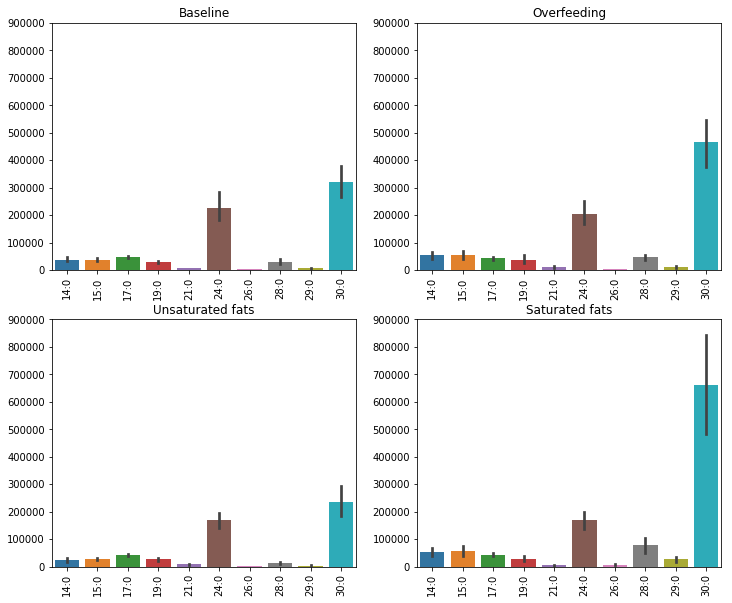

In [344]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))
label = "diet"
labelled_columns = 2

for coord in ((0,0,"Baseline"),(0,1,"Overfeeding"),(1,0,"Unsaturated fats"),(1,1,"Saturated fats")):
    i,j,group = coord
    
    axes[i,j].set_title(f"{group}")
    
    # applying a threshold. Give >= 0 to keep everything
    # ==================================================
    cols = data._get_numeric_data().mean() < 400_000
    cols_to_keep = cols[cols].index
    table = data[cols_to_keep]
    
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[saturated(x) and max_carbon(x, 30) for x in table.columns]]
    
    # putting back sample labels
    table = pd.concat([table, data[data.columns[-labelled_columns:]]], axis=1)   
    
    table=table[table[label] == group]
    
    # we needed to put back the labels to drop non-group rows, now
    # we just need to plot the numbers
    table=table[table.columns[:-labelled_columns]] # only residue columns
    
    bar = sns.barplot(data=table, ax=axes[i, j])
    axes[i,j].tick_params(rotation=90, labelsize=10, axis="x")
    axes[i,j].tick_params(labelsize=10, axis="y")
    axes[i,j].set_ylim(0, 900_000)

print("non abundant saturated residues")
plt.savefig("/Users/manz/Desktop/non abundant saturated residues.png", dpi=600, bbox_inches="tight")

abundant unsaturated residues


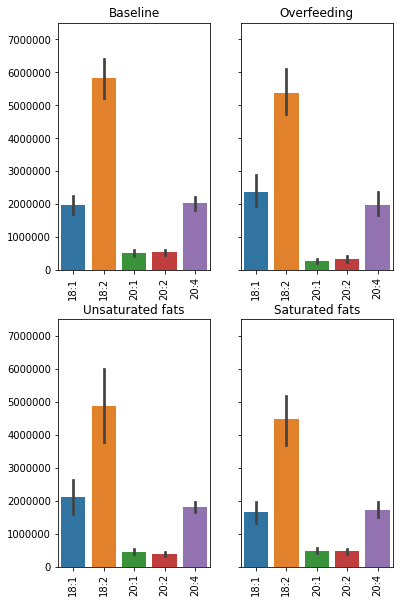

In [345]:
fig, axes = plt.subplots(2, 2, figsize=(6,10))
label = "diet"
labelled_columns = 2

for coord in ((0,0,"Baseline"),(0,1,"Overfeeding"),(1,0,"Unsaturated fats"),(1,1,"Saturated fats")):
    i,j,group = coord
    
    axes[i,j].set_title(f"{group}")
    
    # applying a threshold. Give >= 0 to keep everything
    # ==================================================
    cols = data._get_numeric_data().mean() >= 400_000
    cols_to_keep = cols[cols].index
    table = data[cols_to_keep]
    
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[not saturated(x) and max_carbon(x, 30) for x in table.columns]]
    
    # putting back sample labels
    table = pd.concat([table, data[data.columns[-labelled_columns:]]], axis=1)   
    
    table=table[table[label] == group]
    
    # we needed to put back the labels to drop non-group rows, now
    # we just need to plot the numbers
    table=table[table.columns[:-labelled_columns]] # only residue columns
    
    bar = sns.barplot(data=table, ax=axes[i, j])
    axes[i,j].tick_params(rotation=90, labelsize=10, axis="x")
    if j%2 != 0:
        axes[i,j].set_yticklabels([])
    else:
        axes[i,j].tick_params(labelsize=10, axis="y")
    axes[i,j].set_ylim(0, 7_500_000)

print("abundant unsaturated residues")
#plt.savefig("/Users/manz/Desktop/abundant unsaturated residues.png", dpi=600, bbox_inches="tight")

non abundant unsaturated residues


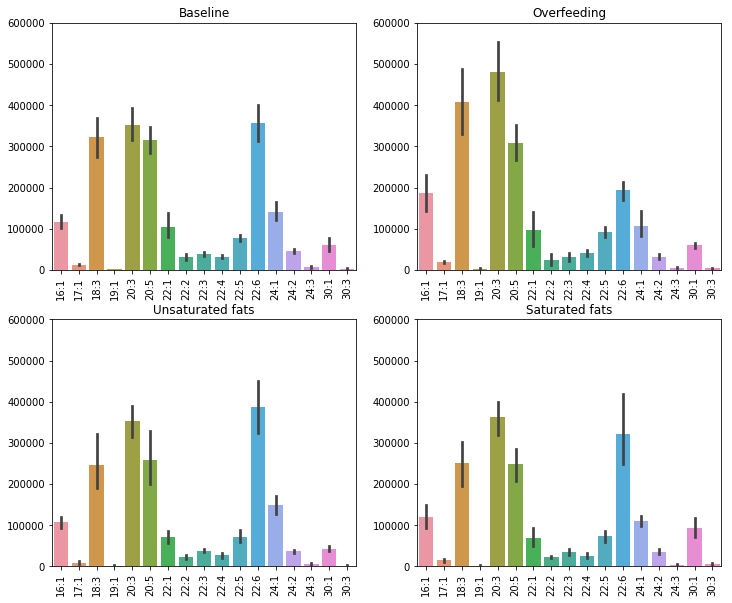

In [346]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))
label = "diet"
labelled_columns = 2

for coord in ((0,0,"Baseline"),(0,1,"Overfeeding"),(1,0,"Unsaturated fats"),(1,1,"Saturated fats")):
    i,j,group = coord
    
    axes[i,j].set_title(f"{group}")
    
    # applying a threshold. Give >= 0 to keep everything
    # ==================================================
    cols = data._get_numeric_data().mean() < 400_000
    cols_to_keep = cols[cols].index
    table = data[cols_to_keep]
    
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[not saturated(x) and max_carbon(x, 30) for x in table.columns]]
    
    # putting back sample labels
    table = pd.concat([table, data[data.columns[-labelled_columns:]]], axis=1)   
    
    table=table[table[label] == group]
    
    # we needed to put back the labels to drop non-group rows, now
    # we just need to plot the numbers
    table=table[table.columns[:-labelled_columns]] # only residue columns
    
    bar = sns.barplot(data=table, ax=axes[i, j])
    axes[i,j].tick_params(rotation=90, labelsize=10, axis="x")
    axes[i,j].tick_params(labelsize=10, axis="y")
    axes[i,j].set_ylim(0, 600_000)

print("non abundant unsaturated residues")
plt.savefig("/Users/manz/Desktop/non abundant unsaturated residues.png", dpi=600, bbox_inches="tight")

# PCA

Text(0, 0.5, 'PC2 (26.68 %)')

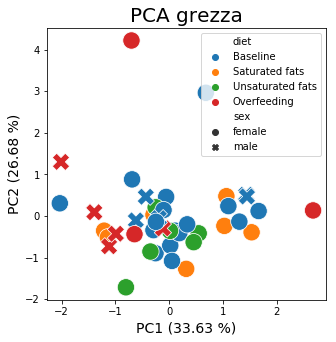

In [384]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pca = PCA(2, whiten=True)

new_coord = pca.fit_transform(df.T)

repack = pd.DataFrame(new_coord, columns=["PC1", "PC2"])
repack["samples"] = list(df.T.index)
repack["diet"] = [get_diet(sample_book.get(x)) for x in df.T.index]
repack["sex"] = ["female" if "female" in sample_book.get(x) else "male" for x in df.T.index]
repack.set_index("samples")

plt.figure(figsize=(5,5))
plt.title("PCA grezza", size=20)

perc1, perc2 = pca.explained_variance_ratio_
sns.scatterplot(x="PC1", y="PC2", data=repack, hue="diet", s=300, style="sex")
plt.xlabel(f"PC1 ({round(perc1*100, 2)} %)", size=14)
plt.ylabel(f"PC2 ({round(perc2*100, 2)} %)", size=14)

Text(0, 0.5, 'PC2 (25.99 %)')

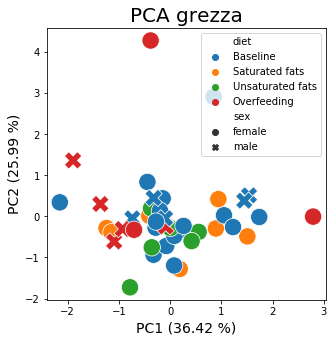

In [374]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pca = PCA(2, whiten=True)

new_coord = pca.fit_transform(res.T)

repack = pd.DataFrame(new_coord, columns=["PC1", "PC2"])
repack["samples"] = list(data.index)
repack["diet"] = [get_diet(sample_book.get(x)) for x in data.index]
repack["sex"] = ["female" if "female" in sample_book.get(x) else "male" for x in data.index]
repack.set_index("samples")

plt.figure(figsize=(5,5))
plt.title("PCA grezza", size=20)

perc1, perc2 = pca.explained_variance_ratio_
sns.scatterplot(x="PC1", y="PC2", data=repack, hue="diet", s=300, style="sex")
plt.xlabel(f"PC1 ({round(perc1*100, 2)} %)", size=14)
plt.ylabel(f"PC2 ({round(perc2*100, 2)} %)", size=14)

# PCA a tre, con intersezioni e 3D

## Residui

In [464]:
pca = PCA(3, whiten=True)

pc = pca.fit_transform(res.T)

repack = pd.DataFrame(pc, columns=["PC1", "PC2", "PC3"])
repack["samples"] = list(res.T.index)
repack["diet"] = [get_diet(sample_book.get(x)) for x in res.T.index]
repack["sex"] = ["female" if "female" in sample_book.get(x) else "male" for x in res.T.index]
repack = repack.set_index("samples")

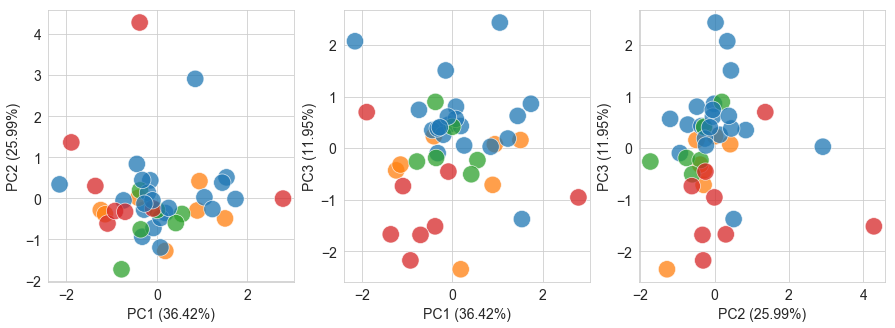

In [465]:
perc1, perc2, perc3 = pca.explained_variance_ratio_
expl_var = {"PC1": perc1,
            "PC2": perc2,
            "PC3": perc3,
           }

# figu
fig, axes = plt.subplots(1, 3, figsize=(15,5))

for i, coord in enumerate((("PC1","PC2"),("PC1", "PC3"),("PC2", "PC3"))):
    x, y = coord
    #axes[i].set_title("title here...")
    
    scattter = sns.scatterplot(
        x=x, y=y, hue="diet", data=repack, s=300, ax=axes[i], alpha=.75
    )

    #axes[i].set_ylim(0,7)
    axes[i].set_xlabel(f"{x} ({round(expl_var.get(x)*100, 2)}%)", size=14)
    axes[i].tick_params(axis='both', which='major', labelsize=14)
    axes[i].set_ylabel(f"{y} ({round(expl_var.get(y)*100, 2)}%)", size=14)
    axes[i].legend().set_visible(False)

    #fig.suptitle("suptitle here..", size=20)
plt.savefig("/users/manz/desktop/PCA_ciccioni_residui.png", dpi=600, bbox_inches="tight")

Explained variance ratio: PC1: 36.0%, PC2: 26.0%, PC3: 36.4%, 


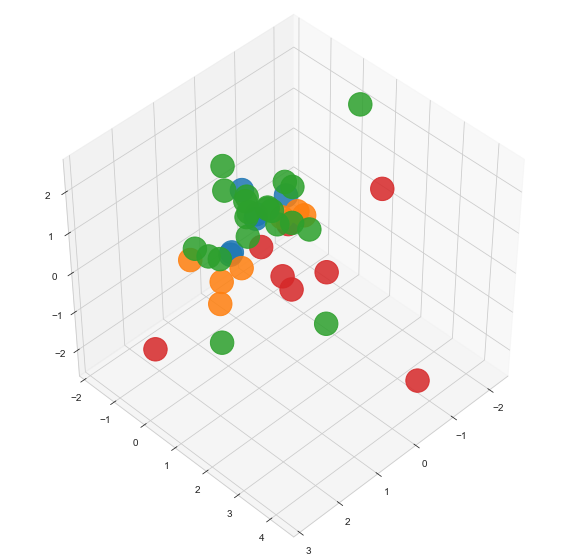

In [466]:
from mpl_toolkits.mplot3d import Axes3D

sns.set_style("whitegrid")


repacked = repack.copy() # saves time, code reuse
if True:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    for g in set(repacked["diet"]):
        #c = colors.get(g)
        #m = marker.get(g)
        #print(f"Group: {g}, color: {c}")
        ax.scatter(
            repacked[repacked["diet"] == g]["PC1"], # x
            repacked[repacked["diet"] == g]["PC2"], # y
            repacked[repacked["diet"] == g]["PC3"], # z
            #c=c, #color
            s=550, #size
            alpha=.85,
            #marker = m,
        )
    # curioso plot dei punti nella griglia..
    
    #ax.view_init(25, 33) #azim=35
    ax.view_init(45, 45) #azim=35
print(f"Explained variance ratio: PC1: {round(perc1, 2)*100}%, PC2: {round(perc2, 2)*100}%, PC3: {round(perc1, 3)*100}%, ")

## Tutti i lipidi

In [467]:
pca = PCA(3, whiten=True)

pc = pca.fit_transform(df.T)

repack = pd.DataFrame(pc, columns=["PC1", "PC2", "PC3"])
repack["samples"] = list(df.T.index)
repack["diet"] = [get_diet(sample_book.get(x)) for x in df.T.index]
repack["sex"] = ["female" if "female" in sample_book.get(x) else "male" for x in df.T.index]
repack = repack.set_index("samples")

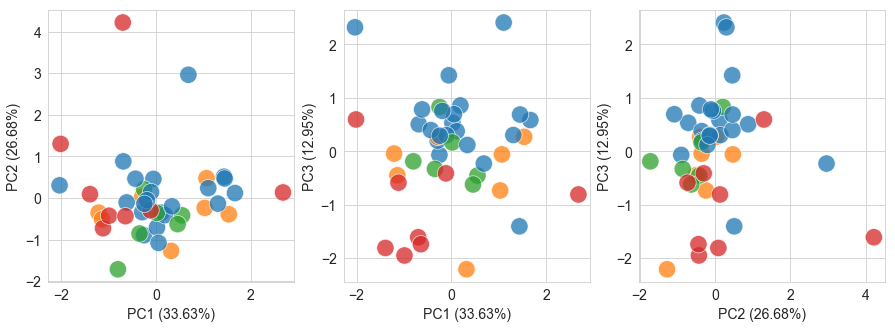

In [468]:
perc1, perc2, perc3 = pca.explained_variance_ratio_
expl_var = {"PC1": perc1,
            "PC2": perc2,
            "PC3": perc3,
           }

# figu
fig, axes = plt.subplots(1, 3, figsize=(15,5))

for i, coord in enumerate((("PC1","PC2"),("PC1", "PC3"),("PC2", "PC3"))):
    x, y = coord
    #axes[i].set_title("title here...")
    
    scattter = sns.scatterplot(
        x=x, y=y, hue="diet", data=repack, s=300, ax=axes[i], alpha=.75
    )

    #axes[i].set_ylim(0,7)
    axes[i].set_xlabel(f"{x} ({round(expl_var.get(x)*100, 2)}%)", size=14)
    axes[i].tick_params(axis='both', which='major', labelsize=14)
    axes[i].set_ylabel(f"{y} ({round(expl_var.get(y)*100, 2)}%)", size=14)
    axes[i].legend().set_visible(False)

    #fig.suptitle("suptitle here..", size=20)
plt.savefig("/users/manz/desktop/PCA_ciccioni_lipidi.png", dpi=600, bbox_inches="tight")

Explained variance ratio: PC1: 34.0%, PC2: 27.0%, PC3: 33.6%, 


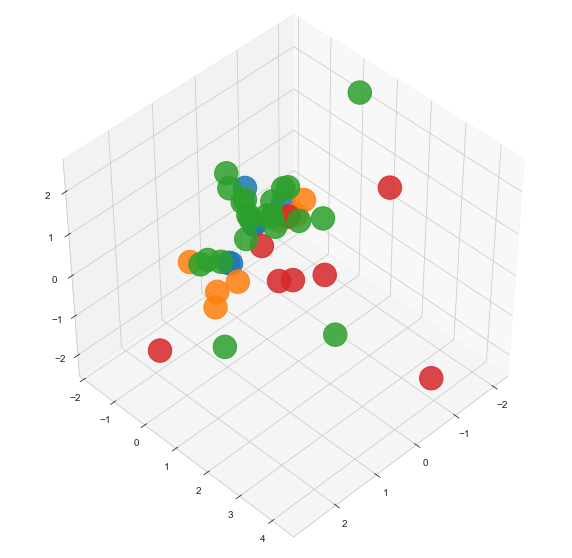

In [469]:
from mpl_toolkits.mplot3d import Axes3D

sns.set_style("whitegrid")


repacked = repack.copy() # saves time, code reuse
if True:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    for g in set(repacked["diet"]):
        #c = colors.get(g)
        #m = marker.get(g)
        #print(f"Group: {g}, color: {c}")
        ax.scatter(
            repacked[repacked["diet"] == g]["PC1"], # x
            repacked[repacked["diet"] == g]["PC2"], # y
            repacked[repacked["diet"] == g]["PC3"], # z
            #c=c, #color
            s=550, #size
            alpha=.85,
            #marker = m,
        )
    # curioso plot dei punti nella griglia..
    
    #ax.view_init(25, 33) #azim=35
    ax.view_init(45, 45) #azim=35
print(f"Explained variance ratio: PC1: {round(perc1, 2)*100}%, PC2: {round(perc2, 2)*100}%, PC3: {round(perc1, 3)*100}%, ")

# per-sample deltas vs baseline

Each subject has two measures: baseline and treatment. To calculate each (baseline - treatment) delta per subject, we need to discriminate the samples.
The files that are downloaded from the study contain this information, but it is cumbersome to read it with ```pandas```. Instead we pull it from the Project's page:
https://www.metabolomicsworkbench.org/data/subject_fetch.php?STUDY_ID=ST000668&STUDY_TYPE=MS&RESULT_TYPE=1

There's no direct handle so we copypaste it into a new spreadsheet.

In [494]:
subjects = pd.read_csv("samples and subjects.txt", sep="\t")

In [478]:
subjects.head(2)

,mb_sample_id,Subject name,Sample name,Diet intervention,Gender
0,SA038455,SU0019532,S00019182,Baseline,female
1,SA038467,SU0019533,S00019184,Baseline,female


Each sample has its own unique ID, but let's check whether there are two measurement per sample:

In [483]:
c = Counter(subjects["Subject name"])
c # for each subject, we have two measures

Counter({'SU0019532': 2,
         'SU0019533': 2,
         'SU0019534': 2,
         'SU0019535': 2,
         'SU0019536': 2,
         'SU0019537': 2,
         'SU0019538': 2,
         'SU0019539': 2,
         'SU0019540': 2,
         'SU0019541': 2,
         'SU0019542': 2,
         'SU0019543': 2,
         'SU0019544': 2,
         'SU0019545': 2,
         'SU0019548': 2,
         'SU0019549': 2,
         'SU0019553': 2,
         'SU0019546': 2,
         'SU0019547': 2,
         'SU0019550': 2,
         'SU0019551': 2,
         'SU0019552': 2})

We now need to process our data so that the columns that hold the samples are paired, then a delta is calculated. (This can be alternatively be done with percentages also, but let's just stick with the deltas).
Let's start by taking notes of the labels:

In [501]:
subjects = subjects.set_index("Subject name")

subjects_book = {}
for k in c:
    subjects_book.setdefault(k, list(s.loc[k]["Sample name"]))

In [504]:
subjects_book

{'SU0019532': ['S00019182', 'S00019183'],
 'SU0019533': ['S00019184', 'S00019185'],
 'SU0019534': ['S00019186', 'S00019187'],
 'SU0019535': ['S00019188', 'S00019189'],
 'SU0019536': ['S00019190', 'S00019191'],
 'SU0019537': ['S00019192', 'S00019193'],
 'SU0019538': ['S00019194', 'S00019195'],
 'SU0019539': ['S00019196', 'S00019197'],
 'SU0019540': ['S00019198', 'S00019199'],
 'SU0019541': ['S00019200', 'S00019201'],
 'SU0019542': ['S00019202', 'S00019203'],
 'SU0019543': ['S00019204', 'S00019205'],
 'SU0019544': ['S00019206', 'S00019207'],
 'SU0019545': ['S00019208', 'S00019209'],
 'SU0019548': ['S00019214', 'S00019215'],
 'SU0019549': ['S00019216', 'S00019217'],
 'SU0019553': ['S00019224', 'S00019225'],
 'SU0019546': ['S00019210', 'S00019211'],
 'SU0019547': ['S00019212', 'S00019213'],
 'SU0019550': ['S00019218', 'S00019219'],
 'SU0019551': ['S00019220', 'S00019221'],
 'SU0019552': ['S00019222', 'S00019223']}

Smartly enough, the baseline conditions are even numbered, and post-treatment values are odd numbered. So we can easily check above that the samples were correctly paired.

The next step is to calculate the deltas of each analyte (I'm choosing Baseline - Treatment) and store the result in a new dataframe.

In [522]:
templist = []
for i, k in enumerate(subjects_book.keys()):
    try:
        col1, col2 = subjects_book.get(k)
        templist.append(res[col1] - res[col2])
    except KeyError:
        print(f"Warning: {k} can't be found among samples ?!")
print(f"Processed {i+1} entries")

Processed 22 entries


In [525]:
print(f"Subjects reported: {len(subjects_book)}")
print(f"Subjects actually present in data: {int(len(df.columns) / 2)}")

Subjects reported: 22
Subjects actually present in data: 21


It looks like there's one missing subject from the published dataset.

In [531]:
residue_deltas = pd.concat(templist, axis=1)

In [533]:
newcols = {old: new for old, new in zip(residue_deltas.columns, subjects_book.keys())}

In [535]:
residue_deltas = residue_deltas.rename(columns=newcols)

Last, we rotate the table and label each sample with each tratment.

In [553]:
dfdelta = residue_deltas.T
dfdelta["diet"] = [list(subjects.loc[key]["Diet intervention"])[1] for key in dfdelta.index]

Now we can plot all the deltas. We should now have olny three treatments, as Baseline served to calculate the deltas with respect to it:

In [712]:
set(dfdelta["diet"])

{'Overfeeding-2 weeks', 'Saturated Fatty Acid', 'Unsaturated Fatty Acid'}

high delta unsaturated residues deltas


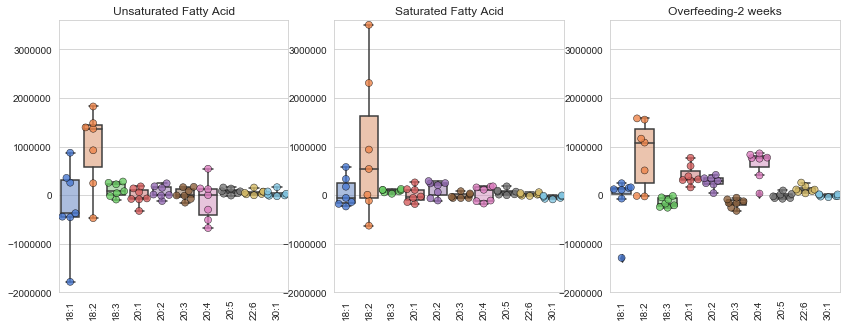

In [728]:
case = "high delta unsaturated residues deltas"

fig, axes = plt.subplots(1, 3, figsize=(14,5))
label = "diet"
labelled_columns = 1

sns.set_palette("muted")
for i, group in enumerate(set(dfdelta["diet"])):
    
    axes[i].set_title(f"{group}")
    
    # applying a threshold. Give >= 0 to keep everything
    # ==================================================
    cols = dfdelta._get_numeric_data().max() >= 150_000
    cols_to_keep = cols[cols].index
    table = dfdelta[cols_to_keep]
    
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[not saturated(x) and max_carbon(x, 30) for x in table.columns]]
    
    # putting back sample labels
    table = pd.concat([table, dfdelta[dfdelta.columns[-labelled_columns:]]], axis=1)   
    
    table=table[table[label] == group]
    
    # we needed to put back the labels to drop non-group rows, now
    # we just need to plot the numbers
    table=table[table.columns[:-labelled_columns]] # only residue columns
    
    #bar = sns.barplot(data=table, ax=axes[i])
    box = sns.boxplot(data=table, ax=axes[i], whis=2)
    for patch in box.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .5))
    swarm = sns.swarmplot(data=table, ax=axes[i], s=7, alpha=.8, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=10, axis="x")
    axes[i].tick_params(labelsize=10, axis="y")
    axes[i].set_ylim(-2_000_000, 3_600_000)

print(case)
#plt.savefig(f"/Users/manz/Desktop/{case}.png", dpi=600, bbox_inches="tight")

low delta unsaturated residues deltas


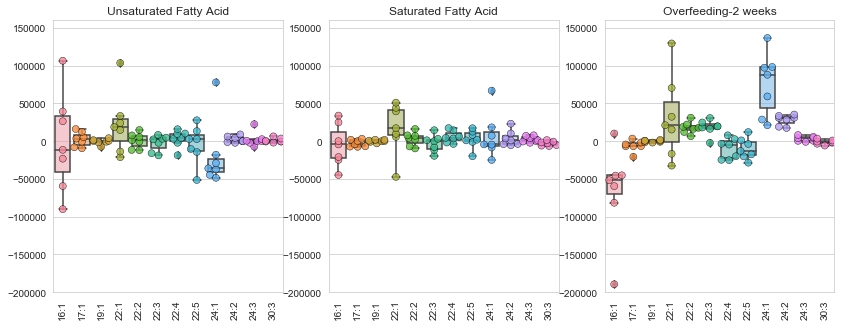

In [730]:
case = "low delta unsaturated residues deltas"

fig, axes = plt.subplots(1, 3, figsize=(14,5))
label = "diet"
labelled_columns = 1

sns.set_palette("muted")
for i, group in enumerate(set(dfdelta["diet"])):
    
    axes[i].set_title(f"{group}")
    
    # applying a threshold. Give >= 0 to keep everything
    # ==================================================
    cols = dfdelta._get_numeric_data().max() < 150_000
    cols_to_keep = cols[cols].index
    table = dfdelta[cols_to_keep]
    
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[not saturated(x) and max_carbon(x, 30) for x in table.columns]]
    
    # putting back sample labels
    table = pd.concat([table, dfdelta[dfdelta.columns[-labelled_columns:]]], axis=1)   
    
    table=table[table[label] == group]
    
    # we needed to put back the labels to drop non-group rows, now
    # we just need to plot the numbers
    table=table[table.columns[:-labelled_columns]] # only residue columns
    
    #bar = sns.barplot(data=table, ax=axes[i])

    box = sns.boxplot(data=table, ax=axes[i], whis=2)
    for patch in box.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .5))
    swarm = sns.swarmplot(data=table, ax=axes[i], s=7, alpha=.8, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=10, axis="x")
    axes[i].tick_params(labelsize=10, axis="y")
    axes[i].set_ylim(-200_000, 160_000)

print(case)
plt.savefig(f"/Users/manz/Desktop/{case}.png", dpi=600, bbox_inches="tight")

high delta saturated residues deltas


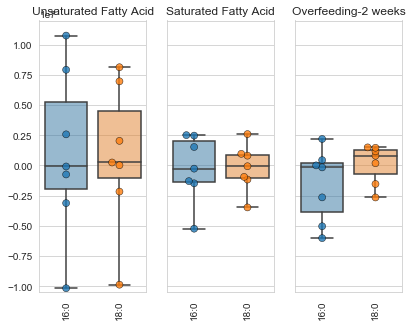

In [715]:
case = "high delta saturated residues deltas"

fig, axes = plt.subplots(1, 3, figsize=(6.5,5))
label = "diet"
labelled_columns = 1

for i, group in enumerate(set(dfdelta["diet"])):
    
    axes[i].set_title(f"{group}")
    
    # applying a threshold. Give >= 0 to keep everything
    # ==================================================
    cols = dfdelta._get_numeric_data().max() >= 1_000_000
    cols_to_keep = cols[cols].index
    table = dfdelta[cols_to_keep]
    
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[saturated(x) and max_carbon(x, 30) for x in table.columns]]
    
    # putting back sample labels
    table = pd.concat([table, dfdelta[dfdelta.columns[-labelled_columns:]]], axis=1)   
    
    table=table[table[label] == group]
    
    # we needed to put back the labels to drop non-group rows, now
    # we just need to plot the numbers
    table=table[table.columns[:-labelled_columns]] # only residue columns
    
    #bar = sns.barplot(data=table, ax=axes[i])
    box = sns.boxplot(data=table, ax=axes[i], whis=2)
    for patch in box.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .5))
    swarm = sns.swarmplot(data=table, ax=axes[i], s=7, alpha=.8, edgecolor="black", linewidth=.5)
    if i != 0:
        axes[i].set_yticklabels([])
    axes[i].tick_params(rotation=90, labelsize=10, axis="x")
    axes[i].tick_params(labelsize=10, axis="y")
    axes[i].set_ylim(-10_500_000, 12_000_000)

print(case)
plt.savefig(f"/Users/manz/Desktop/{case}.png", dpi=600, bbox_inches="tight")

mid-delta saturated residues deltas


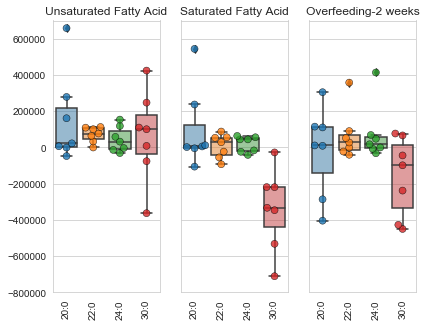

In [716]:
case = "mid-delta saturated residues deltas"

fig, axes = plt.subplots(1, 3, figsize=(6.5,5))
label = "diet"
labelled_columns = 1

for i, group in enumerate(set(dfdelta["diet"])):
    
    axes[i].set_title(f"{group}")
    
    # applying a threshold. Give >= 0 to keep everything
    # ==================================================
    cols = (dfdelta._get_numeric_data().max()  < 1_000_000) & (dfdelta._get_numeric_data().max() > 150_000)
    cols_to_keep = cols[cols].index
    table = dfdelta[cols_to_keep]
    
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[saturated(x) and max_carbon(x, 30) for x in table.columns]]
    
    # putting back sample labels
    table = pd.concat([table, dfdelta[dfdelta.columns[-labelled_columns:]]], axis=1)   
    
    table=table[table[label] == group]
    
    # we needed to put back the labels to drop non-group rows, now
    # we just need to plot the numbers
    table=table[table.columns[:-labelled_columns]] # only residue columns
    
    #bar = sns.barplot(data=table, ax=axes[i])
    box = sns.boxplot(data=table, ax=axes[i], whis=2)
    for patch in box.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .5))
    swarm = sns.swarmplot(data=table, ax=axes[i], s=7, alpha=.8, edgecolor="black", linewidth=.5)
    if i != 0:
        axes[i].set_yticklabels([])
    axes[i].tick_params(rotation=90, labelsize=10, axis="x")
    axes[i].tick_params(labelsize=10, axis="y")
    axes[i].set_ylim(-800_000, 700_000)

print(case)
plt.savefig(f"/Users/manz/Desktop/{case}.png", dpi=600, bbox_inches="tight")

low-delta saturated residues deltas


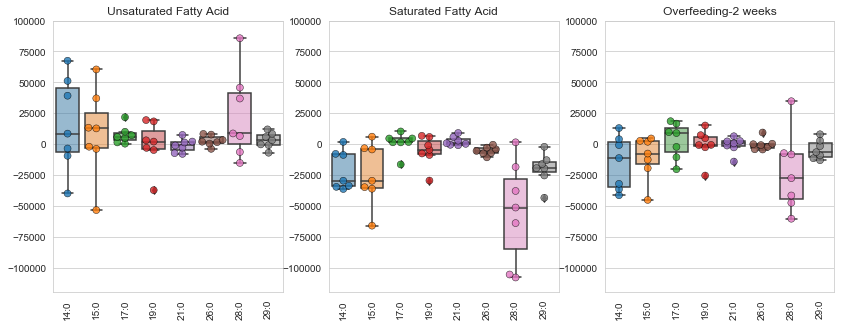

In [717]:
case = "low-delta saturated residues deltas"

fig, axes = plt.subplots(1, 3, figsize=(14,5))
label = "diet"
labelled_columns = 1

for i, group in enumerate(set(dfdelta["diet"])):
    
    axes[i].set_title(f"{group}")
    
    # applying a threshold. Give >= 0 to keep everything
    # ==================================================
    cols = dfdelta._get_numeric_data().max() <= 150_000
    cols_to_keep = cols[cols].index
    table = dfdelta[cols_to_keep]
    
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[saturated(x) and max_carbon(x, 30) for x in table.columns]]
    
    # putting back sample labels
    table = pd.concat([table, dfdelta[dfdelta.columns[-labelled_columns:]]], axis=1)   
    
    table=table[table[label] == group]
    
    # we needed to put back the labels to drop non-group rows, now
    # we just need to plot the numbers
    table=table[table.columns[:-labelled_columns]] # only residue columns
    
    #bar = sns.barplot(data=table, ax=axes[i])
    box = sns.boxplot(data=table, ax=axes[i], whis=2)
    for patch in box.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .5))
    swarm = sns.swarmplot(data=table, ax=axes[i], s=7, alpha=.8, edgecolor="black", linewidth=.5)
    #if i != 0:
    #    axes[i].set_yticklabels([])
    axes[i].tick_params(rotation=90, labelsize=10, axis="x")
    axes[i].tick_params(labelsize=10, axis="y")
    axes[i].set_ylim(-120_000, 100_000)

print(case)
plt.savefig(f"/Users/manz/Desktop/{case}.png", dpi=600, bbox_inches="tight")

# per-sample percentages vs baseline

Last thing left to do is doing the same but with percentages. We will lose an idea how how big the difference against baseline will be (even if we did not have an idea of how much residues there was around, unless looking at the bar charts in the paper), but gain insights on how much there is more or less residue with respect to the starting quantity.

In [932]:
templist = []
for i, k in enumerate(subjects_book.keys()):
    try:
        col1, col2 = subjects_book.get(k)
        base, treatment = res[col1], res[col2]
        templist.append(((treatment - base)/base)*100)
    except KeyError:
        print(f"Warning: {k} can't be found among samples ?!")
print(f"Processed {i+1} entries")

Processed 22 entries


In [933]:
# repacking the results as before
residue_perc = pd.concat(templist, axis=1)
newcols = {old: new for old, new in zip(residue_perc.columns, subjects_book.keys())}

residue_perc = residue_perc.rename(columns=newcols)

dfperc = residue_perc.T
dfperc["diet"] = [list(subjects.loc[key]["Diet intervention"])[1] for key in dfperc.index]

In [934]:
paper_names = {
    "Saturated Fatty Acid" : "Saturated fats",
    "Unsaturated Fatty Acid" : "Unsaturated fats",
    "Overfeeding-2 weeks" : "Overfeeding",
}

In [935]:
dfperc["diet"] = dfperc["diet"].map(paper_names)

In [961]:
#dfperc.to_csv("dfperc.csv", sep="\t")

saturated residues percentages


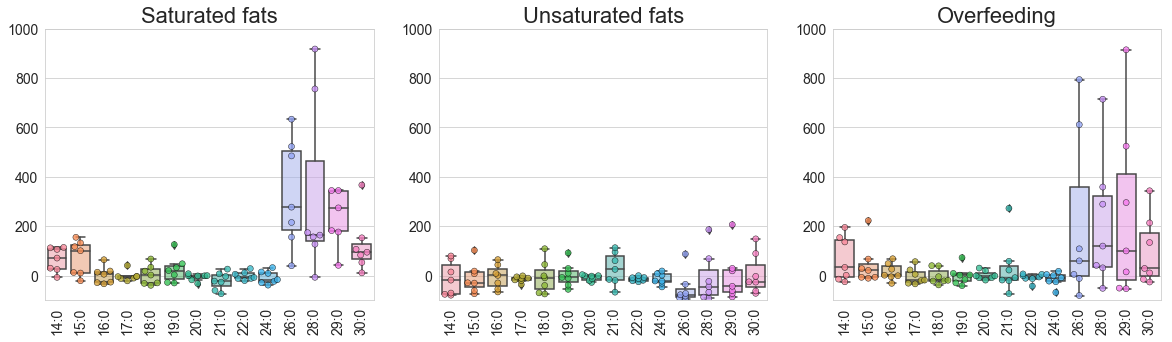

In [957]:
case = "saturated residues percentages"

fig, axes = plt.subplots(1, 3, figsize=(20,5))
label = "diet"
labelled_columns = 1
TITLE_SIZE = 22
TICKSIZE = 14

sns.set_palette("muted")
for i, group in enumerate(('Saturated fats', 'Unsaturated fats', 'Overfeeding')):
    
    axes[i].set_title(f"{group}", size=TITLE_SIZE)
    
    # applying a threshold.
    # ==================================================
    cols = abs(dfperc._get_numeric_data().max()) >= 0 # that is, all of them
    cols_to_keep = cols[cols].index
    table = dfperc[cols_to_keep]
    
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[saturated(x) and max_carbon(x, 30) for x in table.columns]]
    
    # putting back sample labels
    table = pd.concat([table, dfperc[dfperc.columns[-labelled_columns:]]], axis=1)   
    
    table=table[table[label] == group]
    
    # we needed to put back the labels to drop non-group rows, now
    # we just need to plot the numbers
    table=table[table.columns[:-labelled_columns]] # only residue columns
    
    #bar = sns.barplot(data=table, ax=axes[i])
    box = sns.boxplot(data=table, ax=axes[i], whis=1.5)
    for patch in box.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .5))
    swarm = sns.swarmplot(data=table, ax=axes[i], s=6, alpha=.8, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=TICKSIZE, axis="x")
    axes[i].tick_params(labelsize=TICKSIZE, axis="y")
    axes[i].set_ylim(-100, 1000)

print(case)
#plt.savefig(f"/Users/manz/Desktop/{case}.png", dpi=600, bbox_inches="tight")

unsaturated residues percentages


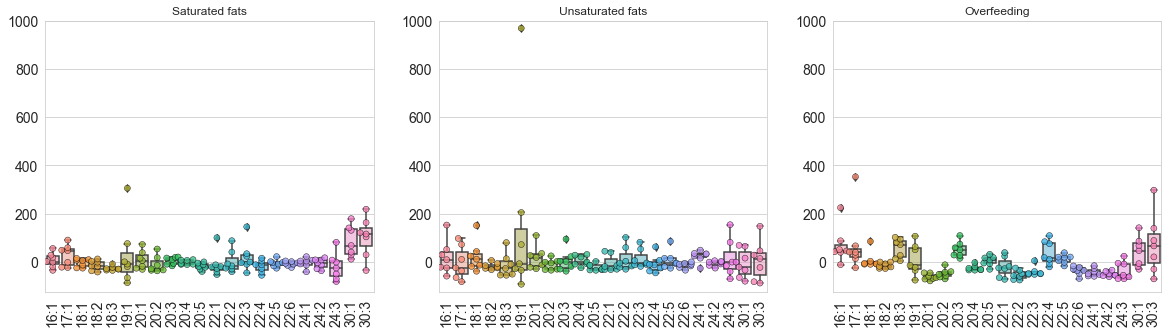

In [955]:
case = "unsaturated residues percentages"

fig, axes = plt.subplots(1, 3, figsize=(20,5))
label = "diet"
labelled_columns = 1
TITLE_SIZE = 22
TICKSIZE = 14

for i, group in enumerate(('Saturated fats', 'Unsaturated fats', 'Overfeeding')):
    
    axes[i].set_title(f"{group}")
    
    # applying a threshold.
    # ==================================================
    cols = abs(dfperc._get_numeric_data().max()) >= 0 # that is, all of them
    cols_to_keep = cols[cols].index
    table = dfperc[cols_to_keep]
    
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[not saturated(x) and max_carbon(x, 30) for x in table.columns]]
    
    # putting back sample labels
    table = pd.concat([table, dfperc[dfperc.columns[-labelled_columns:]]], axis=1)   
    
    table=table[table[label] == group]
    
    # we needed to put back the labels to drop non-group rows, now
    # we just need to plot the numbers
    table=table[table.columns[:-labelled_columns]] # only residue columns
    
    #bar = sns.barplot(data=table, ax=axes[i])
    box = sns.boxplot(data=table, ax=axes[i], whis=2)
    for patch in box.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .5))
    swarm = sns.swarmplot(data=table, ax=axes[i], s=6, alpha=.8, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=TICKSIZE, axis="x")
    axes[i].tick_params(labelsize=TICKSIZE, axis="y")
    axes[i].set_ylim(-125, 1000)

print(case)
#plt.savefig(f"/Users/manz/Desktop/{case}.png", dpi=600, bbox_inches="tight")

unsaturated residues percentages (capped)


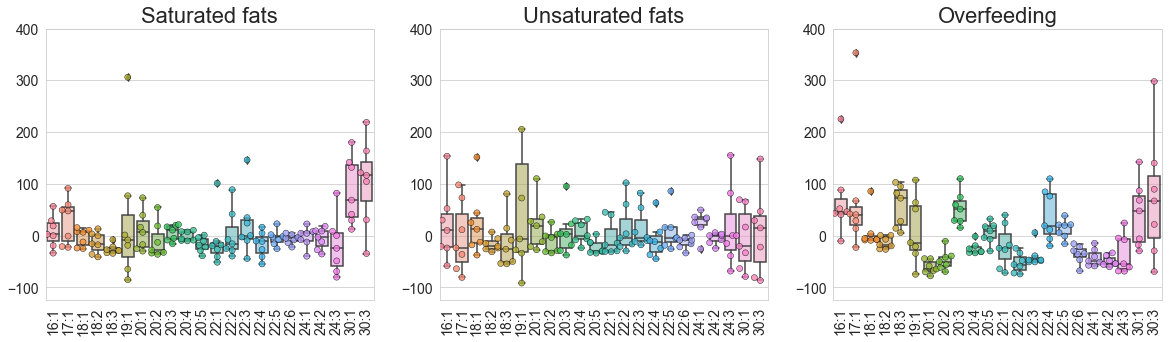

In [956]:
case = "unsaturated residues percentages (capped)"

fig, axes = plt.subplots(1, 3, figsize=(20,5))
label = "diet"
labelled_columns = 1
TITLE_SIZE = 22
TICKSIZE = 14

for i, group in enumerate(('Saturated fats', 'Unsaturated fats', 'Overfeeding')):
    
    axes[i].set_title(f"{group}", size=TITLE_SIZE)
    
    # applying a threshold.
    # ==================================================
    cols = abs(dfperc._get_numeric_data().max()) >= 0 # that is, all of them
    cols_to_keep = cols[cols].index
    table = dfperc[cols_to_keep]
    
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[not saturated(x) and max_carbon(x, 30) for x in table.columns]]
    
    # putting back sample labels
    table = pd.concat([table, dfperc[dfperc.columns[-labelled_columns:]]], axis=1)   
    
    table=table[table[label] == group]
    
    # we needed to put back the labels to drop non-group rows, now
    # we just need to plot the numbers
    table=table[table.columns[:-labelled_columns]] # only residue columns
    
    #bar = sns.barplot(data=table, ax=axes[i])
    box = sns.boxplot(data=table, ax=axes[i], whis=2)
    for patch in box.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .5))
    swarm = sns.swarmplot(data=table, ax=axes[i], s=6, alpha=.8, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=TICKSIZE, axis="x")
    axes[i].tick_params(labelsize=TICKSIZE, axis="y")
    axes[i].set_ylim(-125, 400)

print(case)
#plt.savefig(f"/Users/manz/Desktop/{case}.png", dpi=600, bbox_inches="tight")

# Plotting side by side Baseline and after dietary treatment groups

In [925]:
# Trying to figure out what's going on
debug = data[data["diet"] == "Baseline"].copy()

In [926]:
# taken from online sample details
baseline_samples = {
"Overfeeding" : ['S00019214', 'S00019216', 'S00019218', 'S00019220', 
                 'S00019222', 'S00019224'],
"Unsaturated fats" : ['S00019196', 'S00019200', 'S00019202', 'S00019204', 
                      'S00019206', 'S00019208',],
"Saturated fats" : ['S00019182', 'S00019184', 'S00019186', 'S00019188', 
                    'S00019190', 'S00019192', 'S00019194'],
}

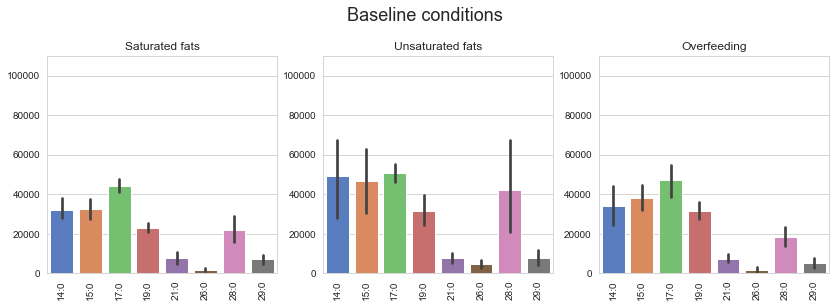

In [950]:
# DEBUG! plot baseline - per - treatment
label = "each baseline, abundant saturated"

fig, axes = plt.subplots(1, 3, figsize=(14,4))
plt.suptitle("Baseline conditions", size=18, y=1.05)
labelled_columns = 2

for i, key in enumerate(("Saturated fats", "Unsaturated fats", "Overfeeding")):
    
    axes[i].set_title(f"{key}")
    
    table = data.loc[baseline_samples.get(key), :].copy()
        
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[saturated(x) and max_carbon(x, 30) for x in table._get_numeric_data().columns]]

    cols = table.max() < 100_000
    cols = cols[cols].index
    table = table[cols]
    BASELINE_COLS = cols.copy()
    
    bar = sns.barplot(data=table, ax=axes[i], 
                      #alpha=.5
                     )
    #swarm = sns.swarmplot(data=table, ax=axes[i], s=10, alpha=.85, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=10, axis="x")
    axes[i].tick_params(labelsize=10, axis="y")
    axes[i].set_ylim(0, 110_000)

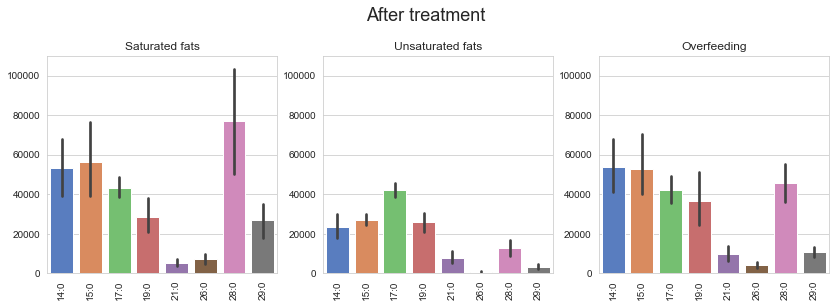

In [949]:
# DEBUG! plot baseline - per - treatment
label = "after treatment, abundant saturated"

fig, axes = plt.subplots(1, 3, figsize=(14,4))
plt.suptitle("After treatment", size=18, y=1.05)
labelled_columns = 2

for i, key in enumerate(("Saturated fats", "Unsaturated fats", "Overfeeding")):
    
    axes[i].set_title(f"{key}")
    
    #table = data.loc[baseline_samples.get(key), :].copy()
    table = data[data["diet"] == key].copy()
    
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[saturated(x) and max_carbon(x, 30) for x in table._get_numeric_data().columns]]

    # the same as previous plot
    table = table[BASELINE_COLS]
    
    bar = sns.barplot(data=table, ax=axes[i], 
                      #alpha=.5
                     )
    #swarm = sns.swarmplot(data=table, ax=axes[i], s=10, alpha=.85, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=10, axis="x")
    axes[i].tick_params(labelsize=10, axis="y")
    axes[i].set_ylim(0, 110_000)

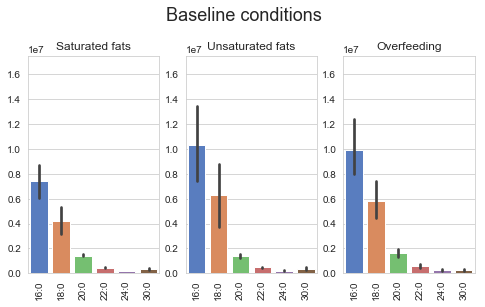

In [929]:
# DEBUG! plot baseline - per - treatment
label = "each baseline, less abundant saturated"

fig, axes = plt.subplots(1, 3, figsize=(8,4))
plt.suptitle("Baseline conditions", size=18, y=1.05)
labelled_columns = 2

for i, key in enumerate(("Saturated fats", "Unsaturated fats", "Overfeeding")):
    
    axes[i].set_title(f"{key}")
    
    table = data.loc[baseline_samples.get(key), :].copy()
        
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[saturated(x) and max_carbon(x, 30) for x in table._get_numeric_data().columns]]

    cols = table.max() >= 100_000
    cols = cols[cols].index
    table = table[cols]
    BASELINE_COLS = cols.copy()
    
    bar = sns.barplot(data=table, ax=axes[i], 
                      #alpha=.5
                     )
    #swarm = sns.swarmplot(data=table, ax=axes[i], s=10, alpha=.85, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=10, axis="x")
    axes[i].tick_params(labelsize=10, axis="y")
    axes[i].set_ylim(0, 17_500_000)

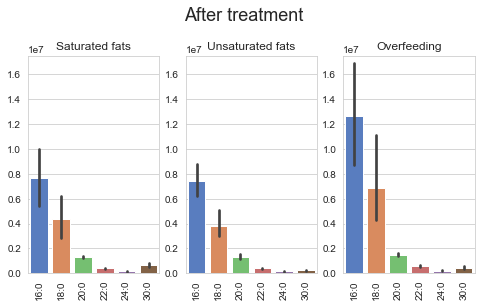

In [930]:
# DEBUG! plot baseline - per - treatment
label = "after treatment, abundant saturated"

fig, axes = plt.subplots(1, 3, figsize=(8,4))
plt.suptitle("After treatment", size=18, y=1.05)
labelled_columns = 2

for i, key in enumerate(("Saturated fats", "Unsaturated fats", "Overfeeding")):
    
    axes[i].set_title(f"{key}")
    
    #table = data.loc[baseline_samples.get(key), :].copy()
    table = data[data["diet"] == key].copy()
    
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[saturated(x) and max_carbon(x, 30) for x in table._get_numeric_data().columns]]

    # the same as previous plot
    table = table[BASELINE_COLS]
    
    bar = sns.barplot(data=table, ax=axes[i], 
                      #alpha=.5
                     )
    #swarm = sns.swarmplot(data=table, ax=axes[i], s=10, alpha=.85, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=10, axis="x")
    axes[i].tick_params(labelsize=10, axis="y")
    axes[i].set_ylim(0, 17_500_000)

In [989]:
#Unsaturated residues

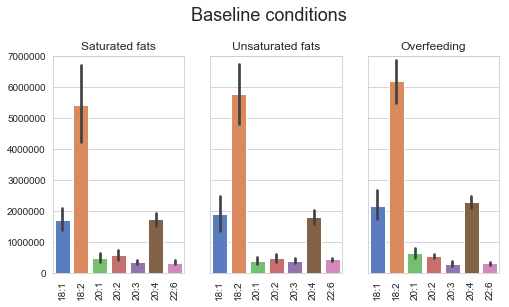

In [990]:
label = "each baseline, abundant unsaturated"

fig, axes = plt.subplots(1, 3, figsize=(8,4))
plt.suptitle("Baseline conditions", size=18, y=1.05)
labelled_columns = 2

for i, key in enumerate(("Saturated fats", "Unsaturated fats", "Overfeeding")):
    
    axes[i].set_title(f"{key}")
    
    table = data.loc[baseline_samples.get(key), :].copy()
        
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[not saturated(x) and max_carbon(x, 30) for x in table._get_numeric_data().columns]]
    
    # these need to be kept the same manually
    if i == 0:
        cols = table.max() > 500_000
        cols = cols[cols].index
    table = table[cols]
    BASELINE_COLS = cols.copy()
    
    bar = sns.barplot(data=table, ax=axes[i], 
                      #alpha=.5
                     )
    #swarm = sns.swarmplot(data=table, ax=axes[i], s=10, alpha=.85, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=10, axis="x")
    axes[i].tick_params(labelsize=10, axis="y")
    if i != 0:
        axes[i].set_yticklabels([])
    axes[i].set_ylim(0, 7_000_000)

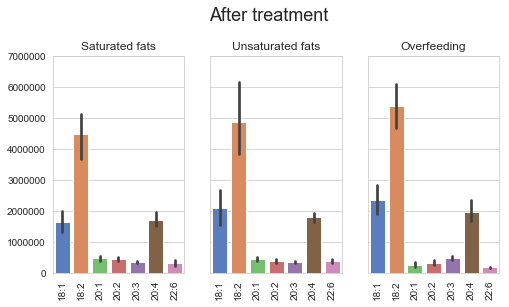

In [991]:
label = "after treatment, abundant unsaturated"

fig, axes = plt.subplots(1, 3, figsize=(8,4))
plt.suptitle("After treatment", size=18, y=1.05)
labelled_columns = 2

for i, key in enumerate(("Saturated fats", "Unsaturated fats", "Overfeeding")):
    
    axes[i].set_title(f"{key}")
    
    #table = data.loc[baseline_samples.get(key), :].copy()
    table = data[data["diet"] == key].copy()
        
    # the same as previous plot
    table = table[BASELINE_COLS]
    
    bar = sns.barplot(data=table, ax=axes[i], 
                      #alpha=.5
                     )
    #swarm = sns.swarmplot(data=table, ax=axes[i], s=10, alpha=.85, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=10, axis="x")
    axes[i].tick_params(labelsize=10, axis="y")
    if i != 0:
        axes[i].set_yticklabels([])
    axes[i].set_ylim(0, 7_000_000)

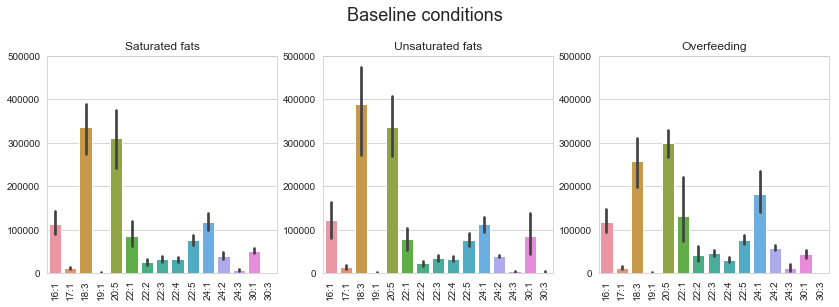

In [992]:
label = "each baseline, abundant unsaturated"

fig, axes = plt.subplots(1, 3, figsize=(14,4))
plt.suptitle("Baseline conditions", size=18, y=1.05)
labelled_columns = 2

for i, key in enumerate(("Saturated fats", "Unsaturated fats", "Overfeeding")):
    
    axes[i].set_title(f"{key}")
    
    table = data.loc[baseline_samples.get(key), :].copy()
        
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[not saturated(x) and max_carbon(x, 30) for x in table._get_numeric_data().columns]]
    
    # these need to be kept the same manually
    if i == 0:
        cols = table.max() <= 500_000
        cols = cols[cols].index
    table = table[cols]
    BASELINE_COLS = cols.copy()
    
    bar = sns.barplot(data=table, ax=axes[i], 
                      #alpha=.5
                     )
    #swarm = sns.swarmplot(data=table, ax=axes[i], s=10, alpha=.85, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=10, axis="x")
    axes[i].tick_params(labelsize=10, axis="y")
    axes[i].set_ylim(0, 500_000)

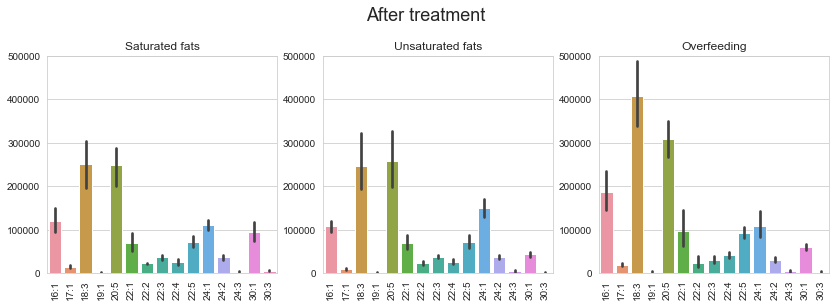

In [994]:
label = "after treatment, abundant unsaturated"

fig, axes = plt.subplots(1, 3, figsize=(14,4))
plt.suptitle("After treatment", size=18, y=1.05)
labelled_columns = 2

for i, key in enumerate(("Saturated fats", "Unsaturated fats", "Overfeeding")):
    
    axes[i].set_title(f"{key}")
    
    #table = data.loc[baseline_samples.get(key), :].copy()
    table = data[data["diet"] == key].copy()
        
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[not saturated(x) and max_carbon(x, 30) for x in table._get_numeric_data().columns]]
    
    # the same as previous plot
    table = table[BASELINE_COLS]
    
    bar = sns.barplot(data=table, ax=axes[i], 
                      #alpha=.5
                     )
    #swarm = sns.swarmplot(data=table, ax=axes[i], s=10, alpha=.85, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=10, axis="x")
    axes[i].tick_params(labelsize=10, axis="y")
    axes[i].set_ylim(0, 500_000)